## サンプルごとの介入によるロスの差の統計的分析

現在の可視化に使ってる元のテーブルはすべてのサンプルのロスの平均．なので，サンプルごとのロスを保存するようにして，手法ごとにロスの差の検定を行う．

利用するサンプル数 N とすると，手法のペアごとに N サンプルの差の検定を 5 (tgt_rank) x 4 (misclf_type_name) 回する．

手法のペア数は？
- betaの数は4通り
- ours以外の比較はbl, random
- ペア数は全部で 8 通りでした．
- 統計的検定自体の数は 8 (ペア数) x 5 (tgt_rank) x 4 (misclf_type_name) = 160 回なので補正が必要ぽい．

In [1]:
import os, sys, time, pickle, json, math
from tqdm import tqdm
from collections import defaultdict
from itertools import product
import numpy as np
import pandas as pd
import torch
from utils.helper import get_device, json2dict
from utils.vit_util import identfy_tgt_misclf, localize_neurons_with_mean_activation, get_batched_hs, get_batched_labels, ViTFromLastLayer
from utils.constant import ViTExperiment, ExperimentRepair1, Experiment3, ExperimentRepair2, Experiment4
from utils.log import set_exp_logging
from logging import getLogger
from datasets import load_from_disk
from transformers import ViTForImageClassification
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
# Notebook向け
%matplotlib inline
from itertools import product
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

device = get_device()

2025-04-22 19:01:43.393188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 19:01:43.473256: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 19:01:43.898932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-04-22 19:01:43.899004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Device: cuda


In [5]:
# 比較対象とパラメータ
methods = ["ours", "bl", "random"]
comparison_pairs = [("fwd_imp", "bl"), ("fwd_imp", "random"), ("bl", "random")]
tgt_ranks = [1, 2, 3, 4, 5]
misclf_types = ["src_tgt", "tgt", "tgt_fp", "tgt_fn"]
sample_types = ["cor", "mis"]
pretrained_dir = ViTExperiment.c100.OUTPUT_DIR.format(k=0) # /src/out_vit_c100_fold0
n = Experiment4.NUM_IDENTIFIED_WEIGHTS
op_list = ["enhance", "suppress", "multiply-2"]


def get_loss_diff_path(n, method, loss_diff_dir, op, cor_mis):
    assert cor_mis in ["cor", "mis"], f"Unknown cor_mis: {cor_mis}"
    if method == "fwd_imp":
        return os.path.join(loss_diff_dir, f"exp-fl-10_loss_diff_n{n}_{op}_{cor_mis}_weight_loss.npy")
    elif method == "bl":
        return os.path.join(loss_diff_dir, f"exp-fl-2_loss_diff_n{n}_{op}_{cor_mis}_weight_bl.npy")
    elif method == "random":
        return os.path.join(loss_diff_dir, f"exp-fl-1_loss_diff_n{n}_{op}_{cor_mis}_weight_random.npy")
    else:
        raise ValueError(f"Unknown method: {method}")


def load_best_loss_diff(n, method, tgt_rank, misclf_type, sample_type, ops=None):
    if ops is None:
        ops = ["enhance", "suppress"]
    loss_diff_dir = os.path.join(pretrained_dir, f"misclf_top{tgt_rank}", f"{misclf_type}_weights_location", "loss_diff_per_sample")
    paths = {
        op: get_loss_diff_path(n, method, loss_diff_dir, op, sample_type)
        for op in ops
    }
    # 存在チェック & 読み込み
    losses = {}
    for op, path in paths.items():
        if not os.path.exists(path):
            raise FileNotFoundError(f"'{op}' の loss_diff ファイルが見つかりません: {path}")
        losses[op] = np.load(path)
    # 形状チェック
    shapes = [arr.shape for arr in losses.values()]
    if not all(shape == shapes[0] for shape in shapes):
        raise AssertionError(f"Shape mismatch among operations: {dict(zip(ops, shapes))}")
    losses = {op: np.load(path) for op, path in paths.items() if os.path.exists(path)}
    # best
    # shape = (num_ops, ...) -> 各サンプルで最小値を取る
    stacked = np.stack(list(losses.values()), axis=0)
    best_losses = np.min(stacked, axis=0)

    return best_losses

def cliffs_delta_from_diff(diff):
    gt = np.sum(diff > 0)
    lt = np.sum(diff < 0)
    n = len(diff)
    return (gt - lt) / n

Comparison pairs: [('fwd_imp', 'bl'), ('fwd_imp', 'random'), ('bl', 'random')]


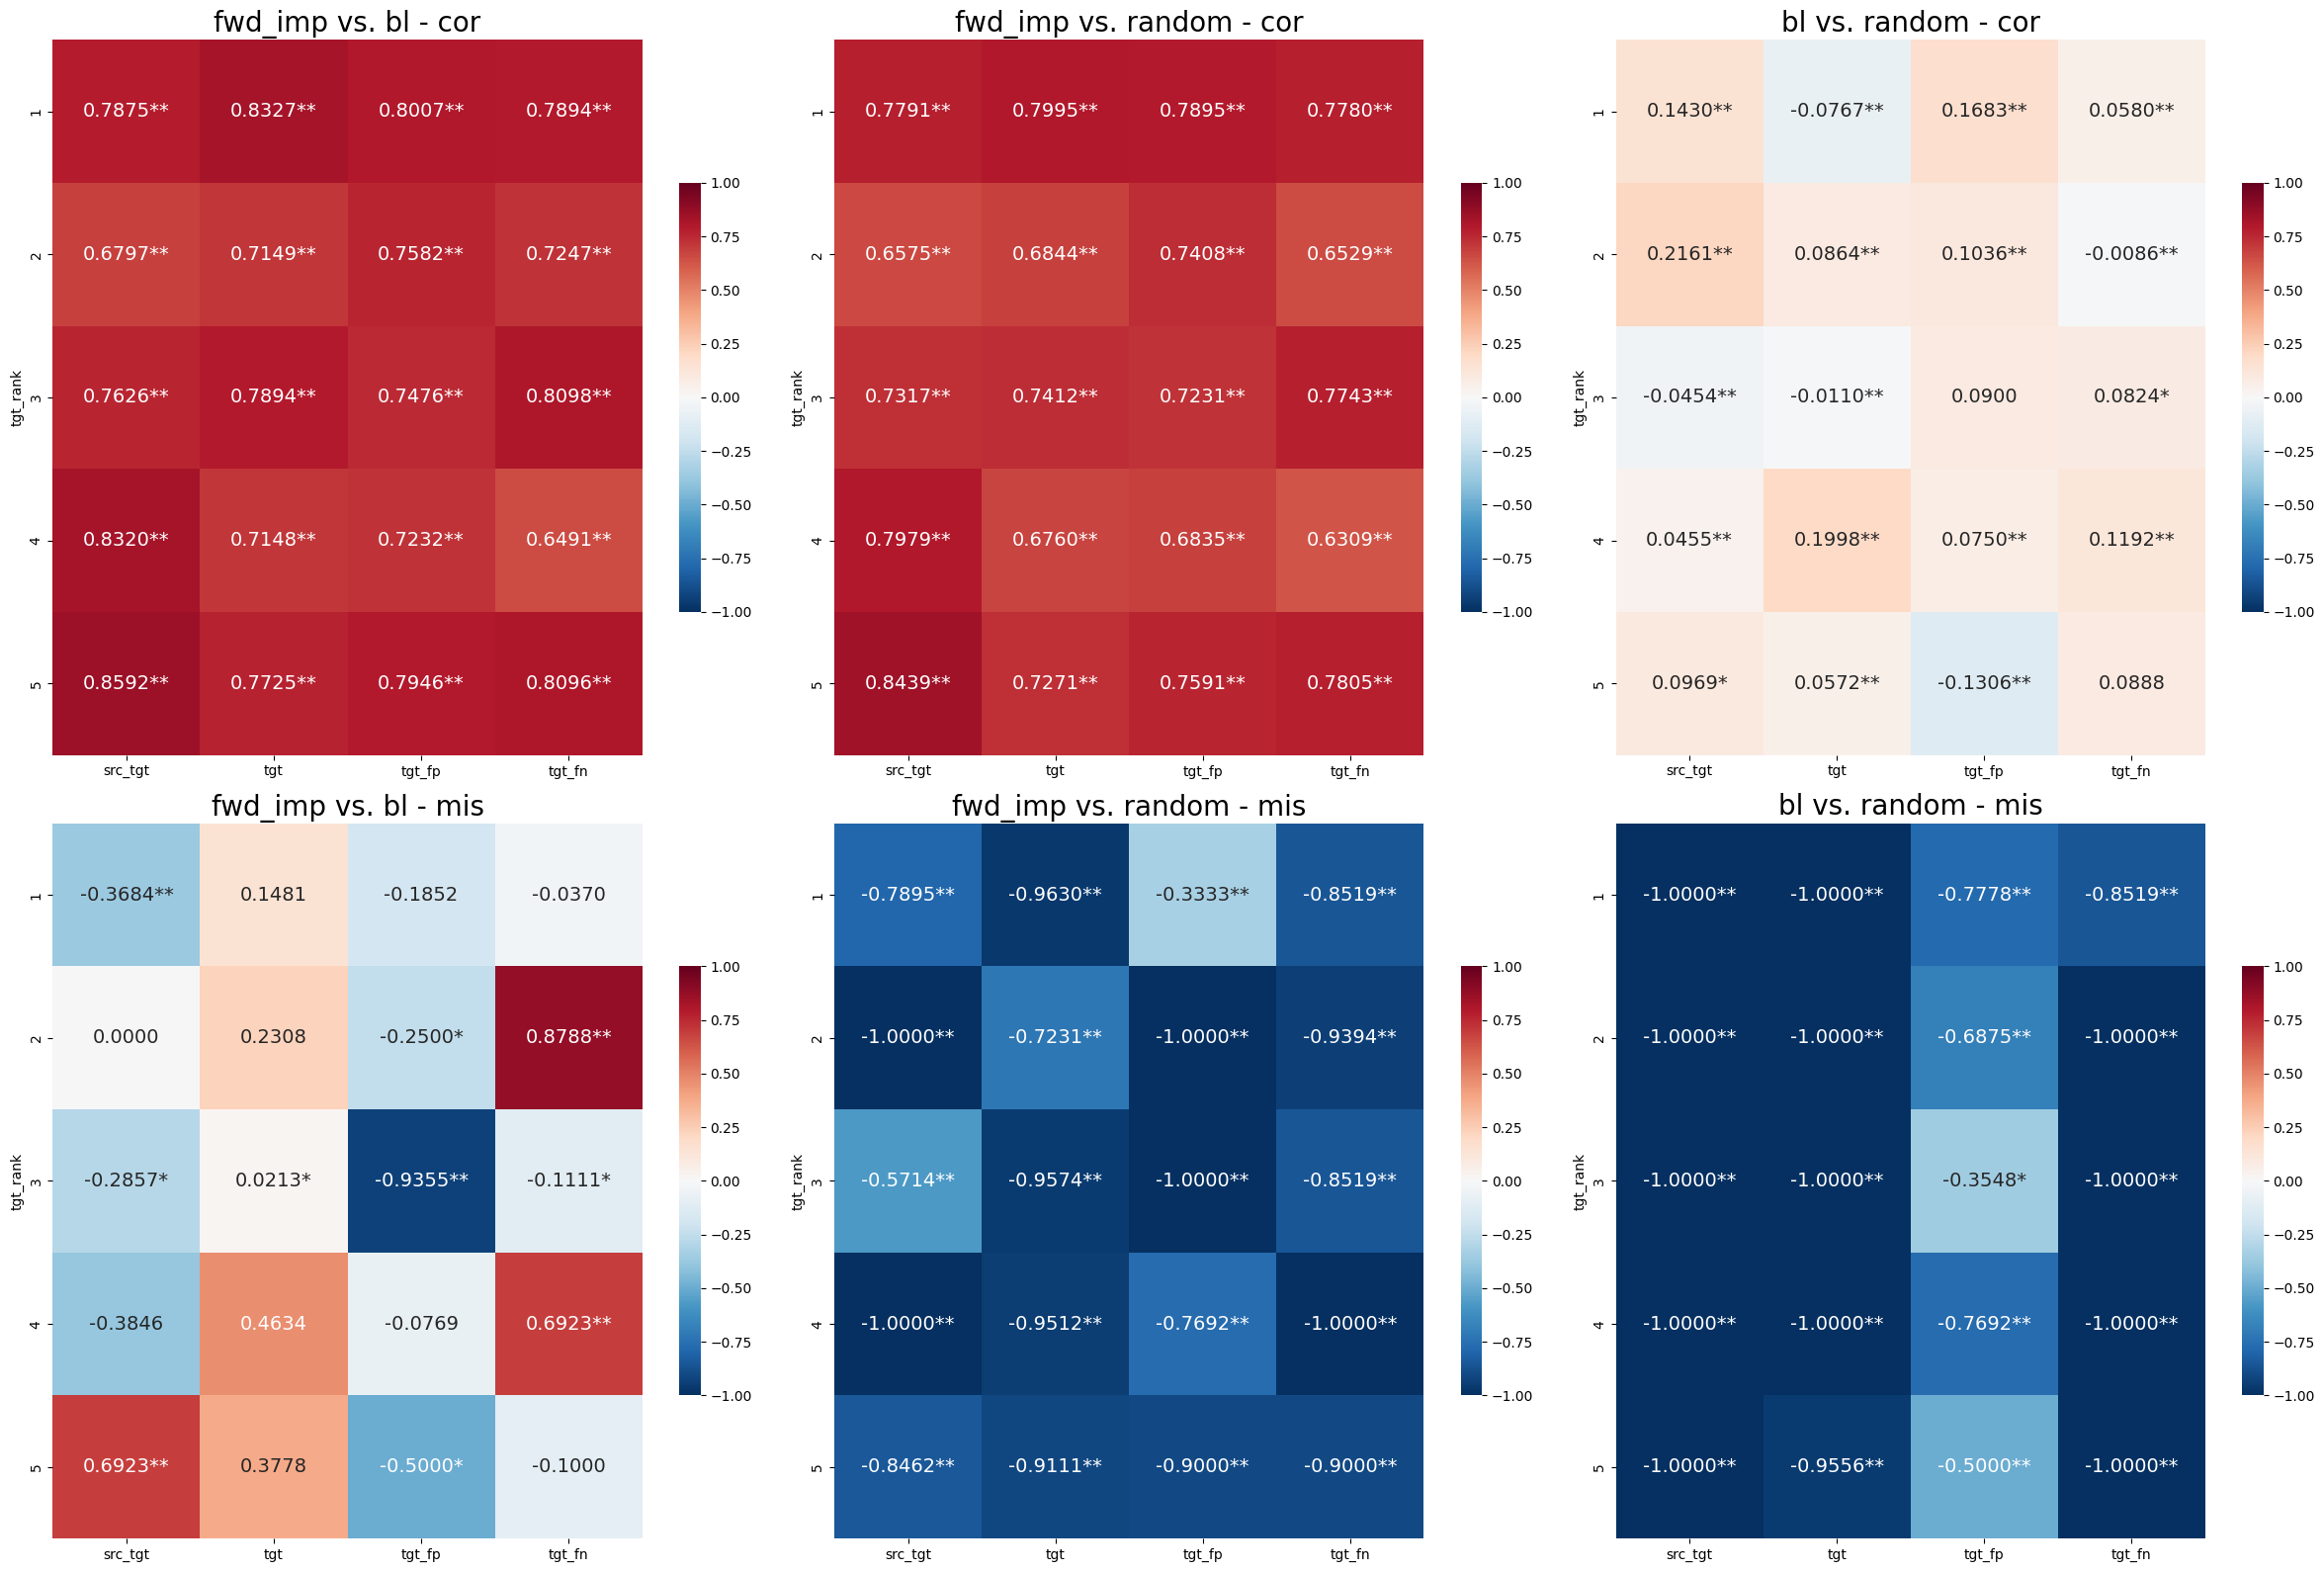

In [6]:
print(f"Comparison pairs: {comparison_pairs}")
fig, axes = plt.subplots(nrows=2, ncols=len(comparison_pairs), figsize=(24, 16))

cmap = "RdBu_r"
for col_idx, (method_a, method_b) in enumerate(comparison_pairs):
    if isinstance(method_a, tuple):
        method_a, _ = method_a
    if isinstance(method_b, tuple):
        method_b, _ = method_b
    # print(f"Comparing {method_a} and {method_b} with beta={beta}")
    ax_dic = {"cor": axes[0, col_idx], "mis": axes[1, col_idx]}
    for sample_type in sample_types:
        p_list = []
        index_list = []
        data = np.zeros((len(tgt_ranks), len(misclf_types)))
        annot = np.empty((len(tgt_ranks), len(misclf_types)), dtype=object)
        for i, tgt_rank in enumerate(tgt_ranks):
            for j, misclf_type in enumerate(misclf_types):
                # print(f"{method_a} vs {method_b} - tgt_rank: {tgt_rank}, misclf_type: {misclf_type}, sample_type: {sample_type}")
                loss_a = load_best_loss_diff(n, method_a, tgt_rank, misclf_type, sample_type, ops=op_list)
                loss_b = load_best_loss_diff(n, method_b, tgt_rank, misclf_type, sample_type, ops=op_list)
                # print(f"misclf_type: {misclf_type}, sample_type: {sample_type}, tgt_rank: {tgt_rank}, method_a: {method_a}, method_b: {method_b}")
                # print(f"loss_a.shape: {loss_a.shape}, loss_b.shape: {loss_b.shape}")
                # 両方のFL手法のロスは同じ長さであることを確認 (同じサンプルに対してのスコアなので)
                assert len(loss_a) == len(loss_b), f"Length mismatch: {len(loss_a)} vs {len(loss_b)}"
                # 両方のFL手法のロスにnanがあってはいけない
                assert not np.isnan(loss_a).any(), f"NaN found in {method_a} loss"
                # 両者のロスのに対して検定を実行
                stat, p = wilcoxon(loss_a, loss_b)
                cliffs_delta = cliffs_delta_from_diff(loss_a - loss_b)
                data[i, j] = cliffs_delta
                p_list.append(p)
                index_list.append((i, j))
                # 有意性によるアノテーション
                if p < 0.01:
                    annot[i, j] = f"{cliffs_delta:.4f}**"
                elif p < 0.05:
                    annot[i, j] = f"{cliffs_delta:.4f}*"
                else:
                    annot[i, j] = f"{cliffs_delta:.4f}"
        df_heat = pd.DataFrame(data, index=tgt_ranks, columns=misclf_types)
        sns.heatmap(df_heat, ax=ax_dic[sample_type], annot=annot, fmt="", cmap=cmap,
                    center=0, vmin=-1, vmax=1, cbar_kws={"shrink": 0.6}, annot_kws={"size": 14},)
        ax_dic[sample_type].set_title(f"{method_a} vs. {method_b} - {sample_type}", fontsize=20)
        # ax_dic[sample_type].set_title(f"Comparing {method_a} and {method_b} with beta={beta}")
        ax_dic[sample_type].set_xlabel("")
        ax_dic[sample_type].set_ylabel("tgt_rank")
plt.tight_layout()
plt.show()

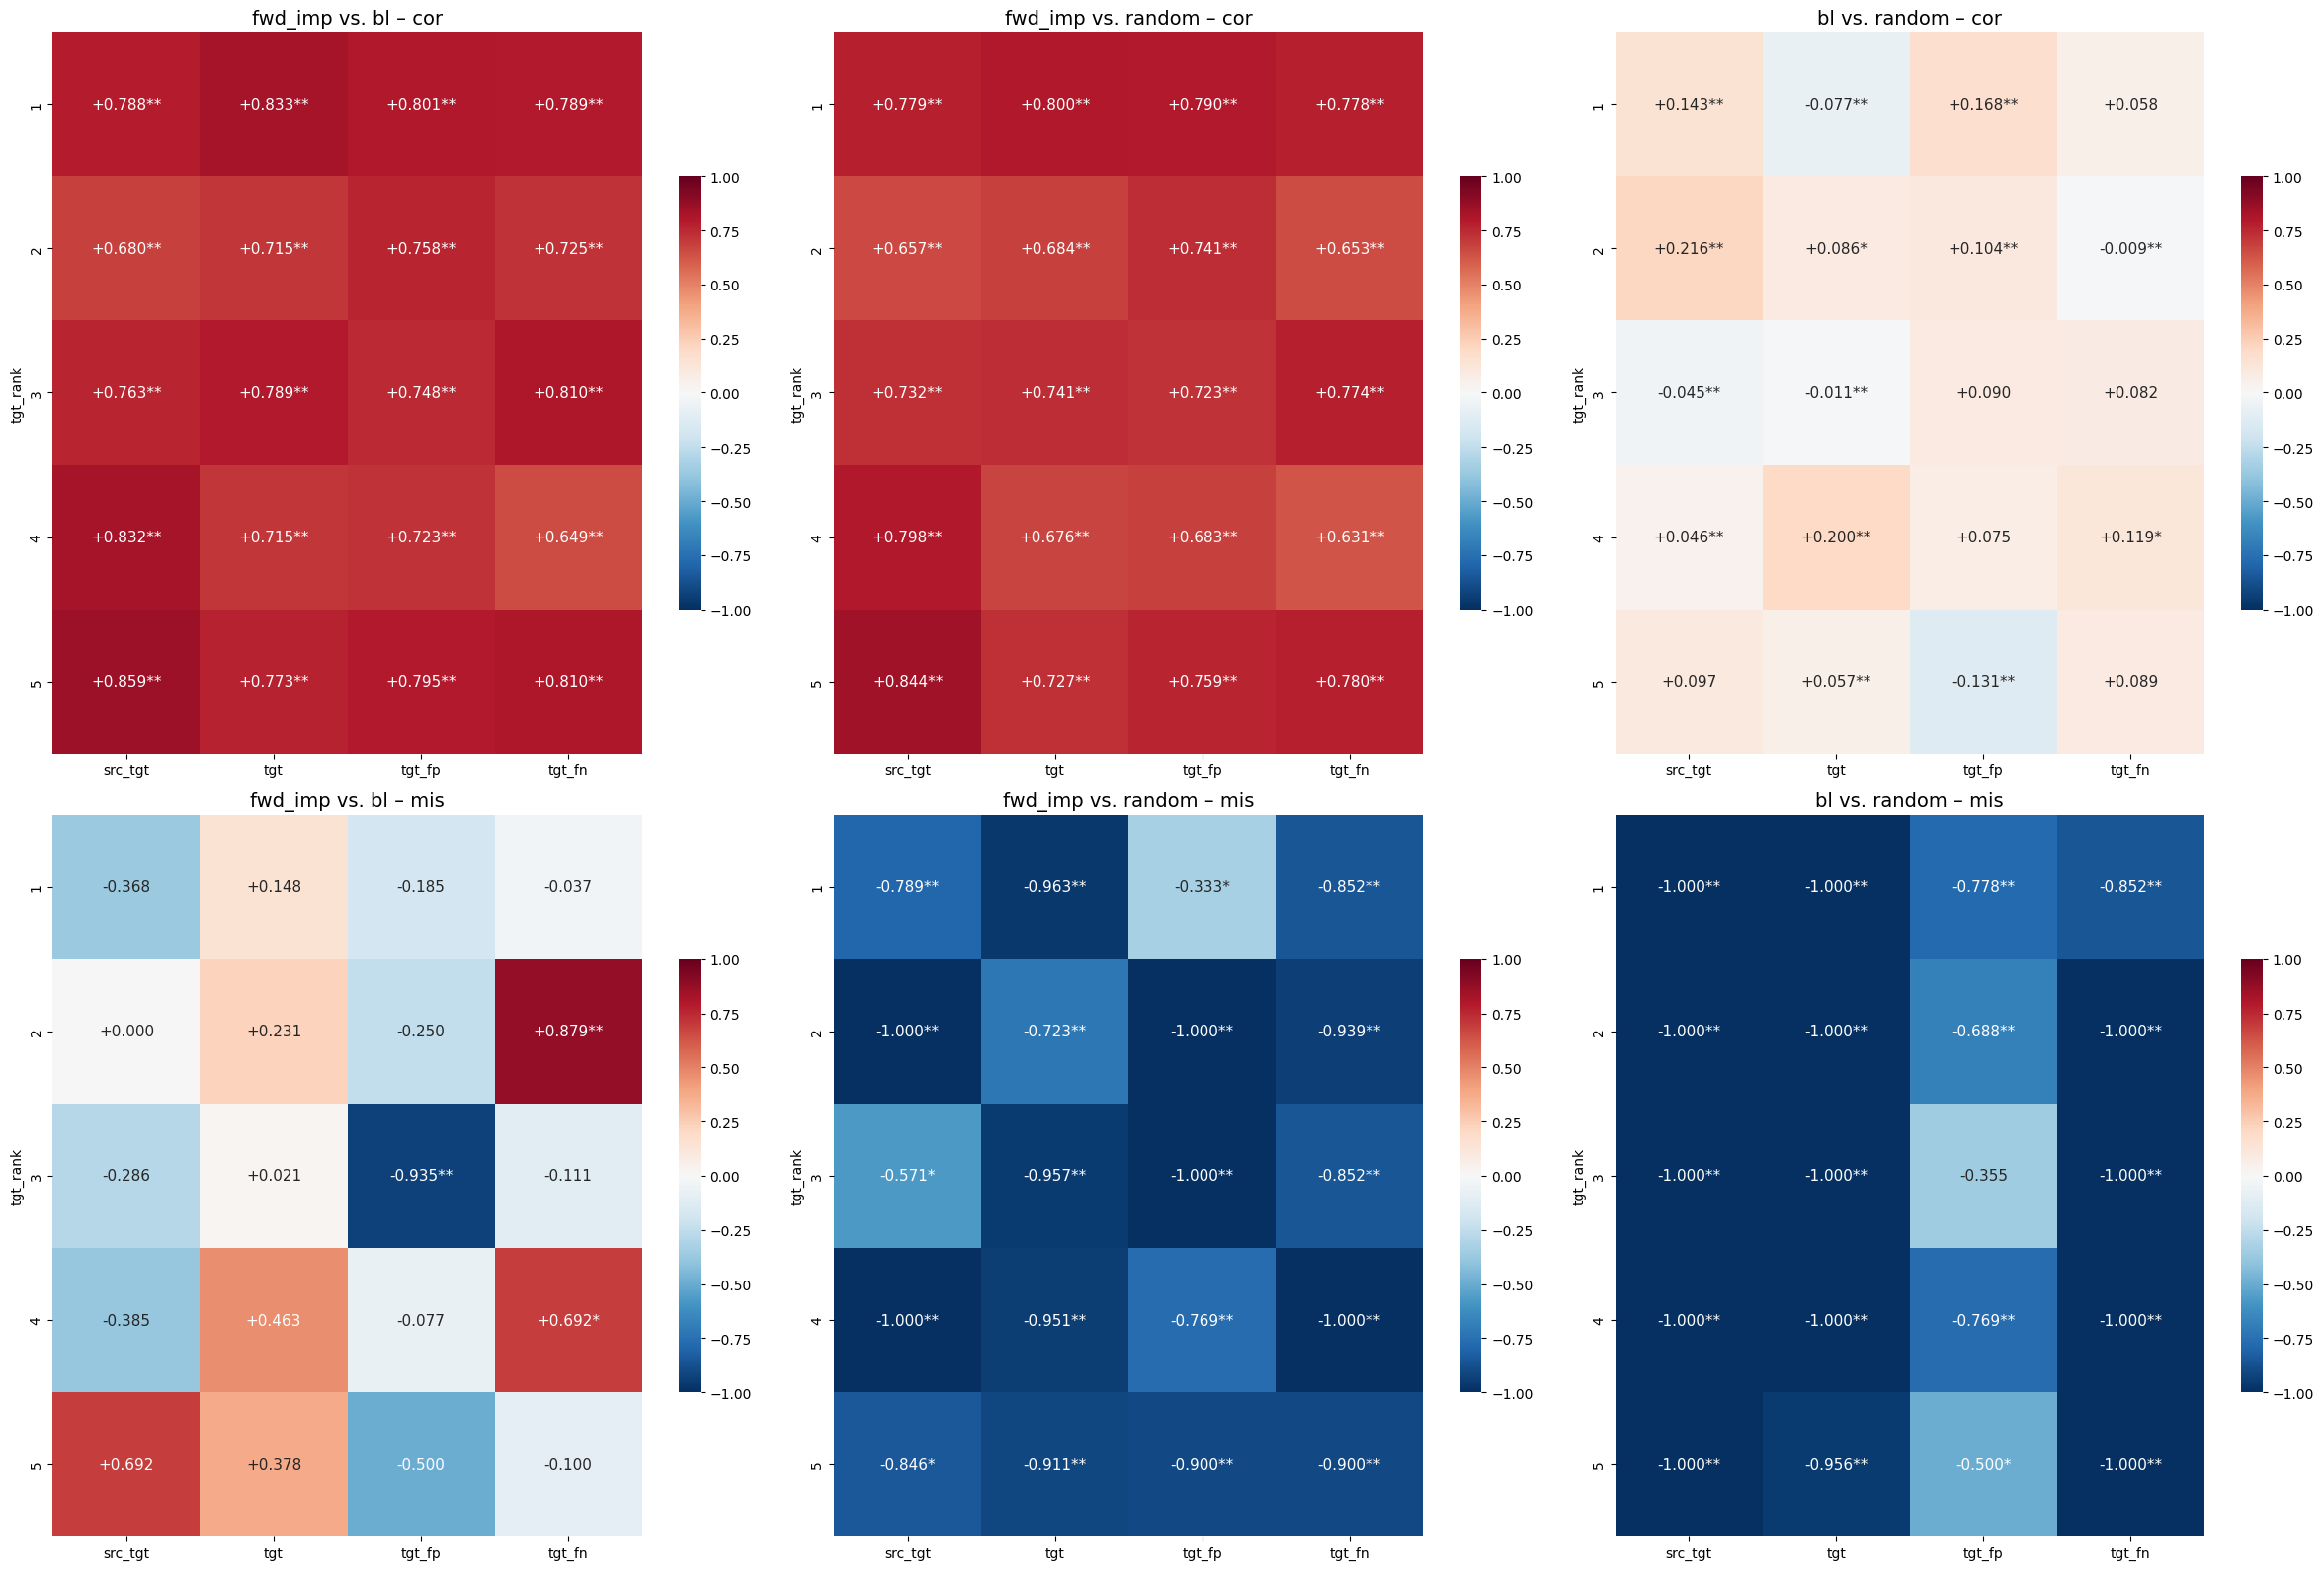

sample         src_tgt             tgt          tgt_fp          tgt_fn        
misclf_type        cor     mis     cor     mis     cor     mis     cor     mis
pair                                                                          
bl–random       (0, 0)  (0, 5)  (0, 0)  (0, 5)  (0, 0)  (0, 4)  (0, 0)  (0, 5)
fwd_imp–bl      (5, 0)  (0, 0)  (5, 0)  (0, 0)  (5, 0)  (0, 1)  (5, 0)  (2, 0)
fwd_imp–random  (5, 0)  (0, 5)  (5, 0)  (0, 5)  (5, 0)  (0, 4)  (5, 0)  (0, 5)

In [7]:
# =========================================================
# 1.  ハイパーパラメータ
# =========================================================
alpha             = 0.05
correction_method = "bonferroni"   # "holm", "fdr_bh", …
thr_delta         = 0.474          # |Δ| ≥ 0.474 : Cliff’s delta “large”
sample_types      = ["cor", "mis"]
tgt_ranks         = [1, 2, 3, 4, 5]
misclf_types      = ["src_tgt", "tgt", "tgt_fp", "tgt_fn"]

# =========================================================
# 2.  判定ヘルパ
# =========================================================
def is_sig(p):               return p < alpha
def large_pos(d):            return d >  thr_delta
def large_neg(d):            return d < -thr_delta

# =========================================================
# 3.  解析ループ
# =========================================================
count_records = []                     # ← ここへ集計を追加
fig, axes = plt.subplots(2, len(comparison_pairs), figsize=(24,16))
cmap = "RdBu_r"

for col_idx, (mA_raw, mB_raw) in enumerate(comparison_pairs):

    method_a = mA_raw[0] if isinstance(mA_raw, tuple) else mA_raw
    method_b = mB_raw[0] if isinstance(mB_raw, tuple) else mB_raw
    ax_dic   = {"cor": axes[0, col_idx], "mis": axes[1, col_idx]}

    for st in sample_types:

        p_list, delta_list, idx_list = [], [], []

        # -------- Wilcoxon & Δ 計算 --------
        for i, r in enumerate(tgt_ranks):
            for j, mc in enumerate(misclf_types):
                a = load_best_loss_diff(n, method_a, r, mc, st, ops=op_list)
                b = load_best_loss_diff(n, method_b, r, mc, st, ops=op_list)

                _, p   = wilcoxon(a, b)
                delta  = cliffs_delta_from_diff(a - b)

                p_list.append(p)
                delta_list.append(delta)
                idx_list.append((i,j))

        # -------- 多重補正 --------
        reject, p_corr_all, *_ = multipletests(p_list, alpha=alpha,
                                                method=correction_method)

        # -------- 表示用行列 & カウント --------
        mat       = np.zeros((len(tgt_ranks), len(misclf_types)))
        annot     = np.empty_like(mat, dtype=object)
        pos_cnt   = np.zeros(len(misclf_types), dtype=int)   # 正方向 large & 有意
        neg_cnt   = np.zeros(len(misclf_types), dtype=int)   # 負方向 large & 有意

        for (i,j), p_corr, rej, delta in zip(idx_list, p_corr_all, reject, delta_list):
            mat[i,j] = delta
            star     = "**" if (rej and p_corr < 0.01) else "*" if (rej and p_corr < 0.05) else ""
            annot[i,j] = f"{delta:+.3f}{star}"

            # ---- large & 有意 を方向別にカウント ----
            if is_sig(p_corr) and large_pos(delta): pos_cnt[j] += 1
            if is_sig(p_corr) and large_neg(delta): neg_cnt[j] += 1

        # -------- ヒートマップ --------
        sns.heatmap(pd.DataFrame(mat, index=tgt_ranks, columns=misclf_types),
                    ax=ax_dic[st], annot=annot, fmt="", cmap=cmap,
                    center=0, vmin=-1, vmax=1,
                    cbar_kws={"shrink":0.6}, annot_kws={"size":11})
        title = f"{method_a} vs. {method_b}"
        ax_dic[st].set_title(f"{title} – {st}", fontsize=14)
        ax_dic[st].set_xlabel("") ; ax_dic[st].set_ylabel("tgt_rank")

        # -------- 集計を１行にまとめて保存 --------
        record = {
            "pair"   : f"{method_a}–{method_b}",
            "sample" : st,
        }
        # (正カウント , 負カウント) のタプルを列に
        for j, mc in enumerate(misclf_types):
            record[mc] = (int(pos_cnt[j]), int(neg_cnt[j]))
        count_records.append(record)

plt.tight_layout(); plt.show()

# =========================================================
# 4.  DataFrame 整形 → Multi‑Index 列
# =========================================================
count_df = pd.DataFrame(count_records)

# ▷ “縦”→“横” : cor / mis を列 Multi‑Index 上位レベルに
wide = (
count_df
    .set_index(["pair","sample"])       # 行：β × ペア × sample
    [misclf_types]                            # ← tuple を持つ４列
    .unstack("sample")                        # 列：sample(level‑0) × misclf_type(level‑1)
)

# 列名レベルを付け直し
wide.columns.names = ["sample", "misclf_type"]

display(wide)          # ← Jupyter 表示

# =========================================================
# 5.  CSV 保存（必要なら）
# =========================================================
# wide.to_csv("exp-fl-4-5.csv")
# print("→ 'exp-fl-4-5.csv' に保存しました")
